In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Dropout, MaxPooling1D, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, Adagrad
from sklearn.metrics import mean_absolute_error

In [ ]:
path = "/content/drive/MyDrive/5DEEP/Jena Climate/data/"

In [ ]:
df = pd.read_csv(f"{path}jena_climate_2009_2016.csv")

In [ ]:
df.info()

In [ ]:
# Conversion de Date Time en datetime
df["Date Time"] = pd.to_datetime(df["Date Time"], format='mixed')

In [ ]:
# On indexe les données en fonction du temps
df.set_index("Date Time", inplace = True)

In [ ]:
df

In [ ]:
fix, ax = plt.subplots(figsize=(15,10))
df["T (degC)"].tail(7200).plot()

## Sélection de variables
On calcule la matrice de corrélations.  
Puis pour chaque couple de variables (i,j) si la corrélation |c_ij| dépasse un seuil de 0.85, alors on abandonne la variable j.

In [ ]:
corr = df.corr()

In [ ]:
corr

In [ ]:
fig, ax = plt.subplots(figsize= (10, 10))
sns.heatmap(corr, annot=True, ax=ax)

In [ ]:
cols_drop = ["Tpot (K)", "Tdew (degC)", "VPact (mbar)", "VPmax (mbar)", 'max. wv (m/s)']

In [ ]:
df_2 = df.copy()

In [ ]:
df_2 = df_2.drop(cols_drop, axis=1)

In [ ]:
df_2

## Création du jeu de données

In [ ]:
target = "T (degC)"

In [ ]:
X = df_2 # On ne drop pas target puisque les prédictions de la température se feront aussi sur les valeurs de température antérieures
y = df_2[target]

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# Calcul des indices pour le découpage en jeux de Train, Validation et Test
# ##########
# ###### ## ##
indice_split_1 = int(len(X)*0.6)
indice_split_2 = int(len(X)*0.8)
print(indice_split_1)
print(indice_split_2)

In [ ]:
X_train_data = X.iloc[ : indice_split_1 ]
X_val_data = X.iloc[ indice_split_1 : indice_split_2 ]
X_test_data = X.iloc[ indice_split_2 : ]

In [ ]:
def normalize(X):
  mini = X.min(axis=0)
  maxi = X.max(axis=0)

  return (X-mini)/(maxi-mini)

In [ ]:
X_train_data_norm = normalize(X_train_data)
X_val_data_norm = normalize(X_val_data)
X_test_data_norm = normalize(X_test_data)

In [ ]:
print(X_train_data_norm.shape)
print(X_val_data_norm.shape)
print(X_test_data_norm.shape)

In [ ]:
# Le pas d'échantillonnage dans les données: on veut un relevé par heure donc on prend une valeur sur 6
step = 6

# Nombre de jours dans le passé
days = 5

# Nombre de données dans X_train_data à parcourir pour construire une séquence qui s'étale sur 5 jours
past = step*days*24

# Nombre de données dans le futur pour lire la valeur de y
future = step*1*24

# Nombre de données dans la séquence temporelle
sequence_length = past/step

In [ ]:
sequence_length

## Jeu d'entraînement

In [ ]:
# Calcul des indices dans X_train_data et y pour pouvoir construire les séquences

x_start = 0
x_end = len(X_train_data_norm)

y_start = past
y_end = past + len(X_train_data_norm)


In [ ]:
X_train_before_sampling = X_train_data_norm[ x_start : x_end ]
y_train_before_sampling = y.iloc[y_start : y_end].values
y_train_before_sampling = np.expand_dims(y_train_before_sampling, -1) # nécessaire pour passer de (252330,) à (252330,1) pour pouvoir utiliser timeseries_dataset_from_array

In [ ]:
print(X_train_before_sampling.shape)
print(y_train_before_sampling.shape)

In [ ]:
dataset_train = timeseries_dataset_from_array(
    X_train_before_sampling,
    y_train_before_sampling,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size = len(X_train_before_sampling)
)

In [ ]:
for X_train, y_train in dataset_train.take(1):
  print(X_train.shape)
  print(y_train.shape)

In [ ]:
X_train[0] # La première séquence temporelle
y_train[0] # Température à prédire avec la première séquence temporelle de X_train

##  Jeu de validation

In [ ]:
x_start = 0
x_end = len(X_val_data)

y_start = past + len(X_train_data)
y_end = y_start + len(X_val_data)

In [ ]:
X_val_before_sampling = X_val_data_norm[ x_start : x_end ]
y_val_before_sampling = y.iloc[ y_start : y_end ].values
y_val_before_sampling = np.expand_dims(y_val_before_sampling, -1)

In [ ]:
print(X_val_before_sampling.shape)
print(y_val_before_sampling.shape)

In [ ]:
dataset_val = timeseries_dataset_from_array(
    X_val_before_sampling,
    y_val_before_sampling,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size = len(X_val_before_sampling)
)

In [ ]:
for X_val, y_val in dataset_val.take(1):
  print(X_val.shape)
  print(y_val.shape)

## Jeu de test

In [ ]:
x_start = 0
x_end = len(X_test_data) - (past + future)

y_start = y_start + len(X_val_data)
y_end = len(y) - future

In [ ]:
X_test_before_sampling = X_test_data_norm[ x_start : x_end ]
y_test_before_sampling = y.iloc[ y_start : y_end ].values
y_test_before_sampling = np.expand_dims(y_test_before_sampling, -1)

In [ ]:
print(X_test_before_sampling.shape)
print(y_test_before_sampling.shape)

In [ ]:
dataset_test = timeseries_dataset_from_array(
    X_test_before_sampling,
    y_test_before_sampling,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size = len(X_test_before_sampling)
)

In [ ]:
for X_test, y_test in dataset_test.take(1):
  print(X_test.shape)
  print(y_test.shape)

In [ ]:
y_test

In [ ]:
def evaluate_naive_modele():
  shift = 6*24

  # Exemple avec un shift = 2
  #
  # t       012345678
  # y_test [abcdefghi]
  #          \\\\\\\\\
  # y_pred [..abcdefghi]
  # t       0123456
  #
  # Interprétation :
  # À la date t=0, ou t=1, aucune prédiction ne peut être faite
  # À la date t=2, la température vaut c, la prédiction est a
  # Etc.
  #
  # Il faut donc comparer c <-> a, d <-> b, e <-> c, etc.
  # On construit donc :
  # y_1 = [cdefghi]   (y_test[ shift :  ])
  # y_2 = [abcdefg]   (y_test[ : -shift ])
  # Et on calcule MAE(y_1, y_2)

  y_1 = y_test.numpy()[ shift :  ]
  y_2 = y_test.numpy()[ : -shift ]

  # Affichage des 1000 premières températures
  fig, ax = plt.subplots(figsize = (15,10))

  ax1 = pd.Series(y_1.reshape(-1)).head(1000).plot(label="Températures (°C)", color="blue")
  ax2 = pd.Series(y_2.reshape(-1)).head(1000).plot(label="Prédictions (°C)", secondary_y=True, color="orange")

  h1, l1 = ax1.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()

  plt.legend(h1+h2, l1+l2, loc=2)
  plt.show()

  # Calcul de la performance du modèle naïf
  res = mean_absolute_error(y_1, y_2)
  return res



In [ ]:
mae_modele_naif = evaluate_naive_modele()

## Modèle à 1 neurone

## Fonction d'évaluation des modèles

In [ ]:
performances = {"Modele naif" : {"MAE": mae_modele_naif}}

In [ ]:
import json

def evaluate_model(model, name, X_test, y_test, history=None):

  # S'il y a un historique, on le trace
  if history:
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(history.history["loss"], c="blue")
    axes[0].plot(history.history["val_loss"], c="orange")
    axes[1].plot(history.history["mae"], c="blue")
    axes[1].plot(history.history[f"val_mae"], c="orange")
    plt.show()

  # On trace les valeurs prédites vs les vraies températures
  y_pred = model.predict(X_test).reshape(-1) # (1000, 1) -> (1000, )
  y_test_tmp = y_test.numpy().reshape(-1)

  fig, ax = plt.subplots(figsize=(15, 10))
  pd.Series(y_pred).head(1000).plot()
  pd.Series(y_test_tmp).head(1000).plot()
  plt. plot()

  # Calcul de la MAE
  res = mean_absolute_error(y_pred, y_test_tmp)
  performances[name] = {"MAE": res}

  print("Comparaison des modèles:")
  print(json.dumps(performances, indent=2))

  return res

In [ ]:
input_shape = X_train.shape[1:]
output_dim = y_train.shape[1]
print(input_shape)
print(output_dim)

In [ ]:
def create_nn_1_model():
  """
  Un modèle à 1 neurone avec identité en fonction d'activation réalise une régression linéaire:
  y_pred = f(w_0 + w_1*x_1 + ... + w_n*x_n) = w_0 + w_1*x_1 + ... + w_n*x_n
  """
  model = Sequential()

  model.add(Input(shape=input_shape))
  model.add(Flatten())

  # Couche de sortie
  model.add(Dense(output_dim, activation="linear")) # Fonction identité

  model.compile(
      optimizer = Adagrad(),
      loss = "mae",
      metrics = ["mae"]
  )
  model.summary()

  return model



In [ ]:
nn_1_model = create_nn_1_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1080)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,081 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081 (4.22 KB)

 Trainable params: 1,081 (4.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nb_epochs = 10

In [ ]:
history_nn_1_model = nn_1_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = nb_epochs)

Epoch 1/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 5.3324 - mae: 5.3324 - val_loss: 3.3486 - val_mae: 3.3486
Epoch 2/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 3.3496 - mae: 3.3496 - val_loss: 3.5378 - val_mae: 3.5378
Epoch 3/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 3.1063 - mae: 3.1063 - val_loss: 3.5810 - val_mae: 3.5810
Epoch 4/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.9494 - mae: 2.9494 - val_loss: 3.5502 - val_mae: 3.5502
Epoch 5/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 2.8541 - mae: 2.8541 - val_loss: 3.5024 - val_mae: 3.5024
Epoch 6/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2.7676 - mae: 2.7676 - val_loss: 3.4903 - val_mae: 3.4903
Epoch 7/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 2.7003 - mae: 2.7003 - val_loss: 3.4685 - val_mae: 3.4685
Epoch 8/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 2.6295 - mae: 2.6295 - val_loss: 3.4610 - val_mae: 3.4610
Epoch 9/10
7863/7863 ━━━━━━━━━━━

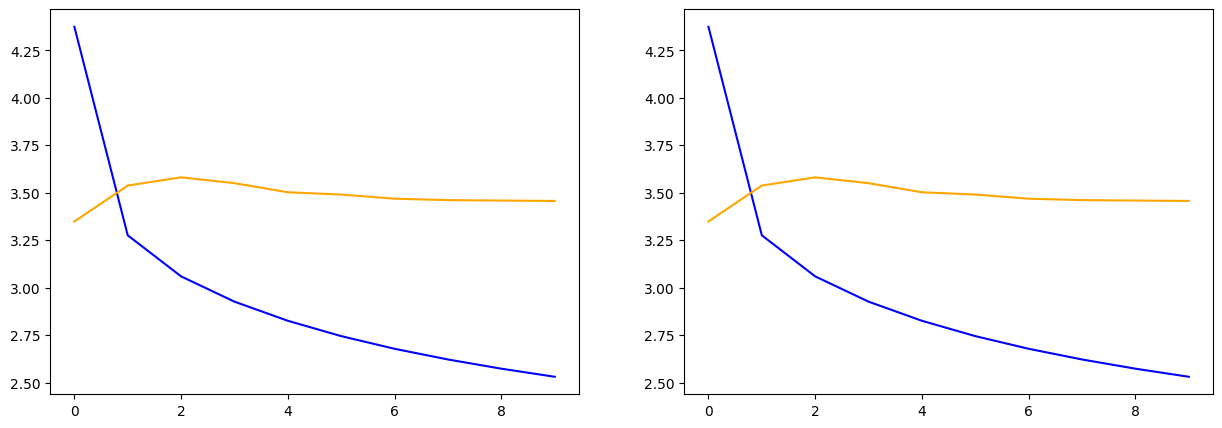

2580/2580 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Comparaison des modèles:
{
  "Modele naif": {
    "MAE": 2.59358882860576
  },
  "NN 1 neurone": {
    "MAE": 3.822216208208877
  }
}


3.822216208208877

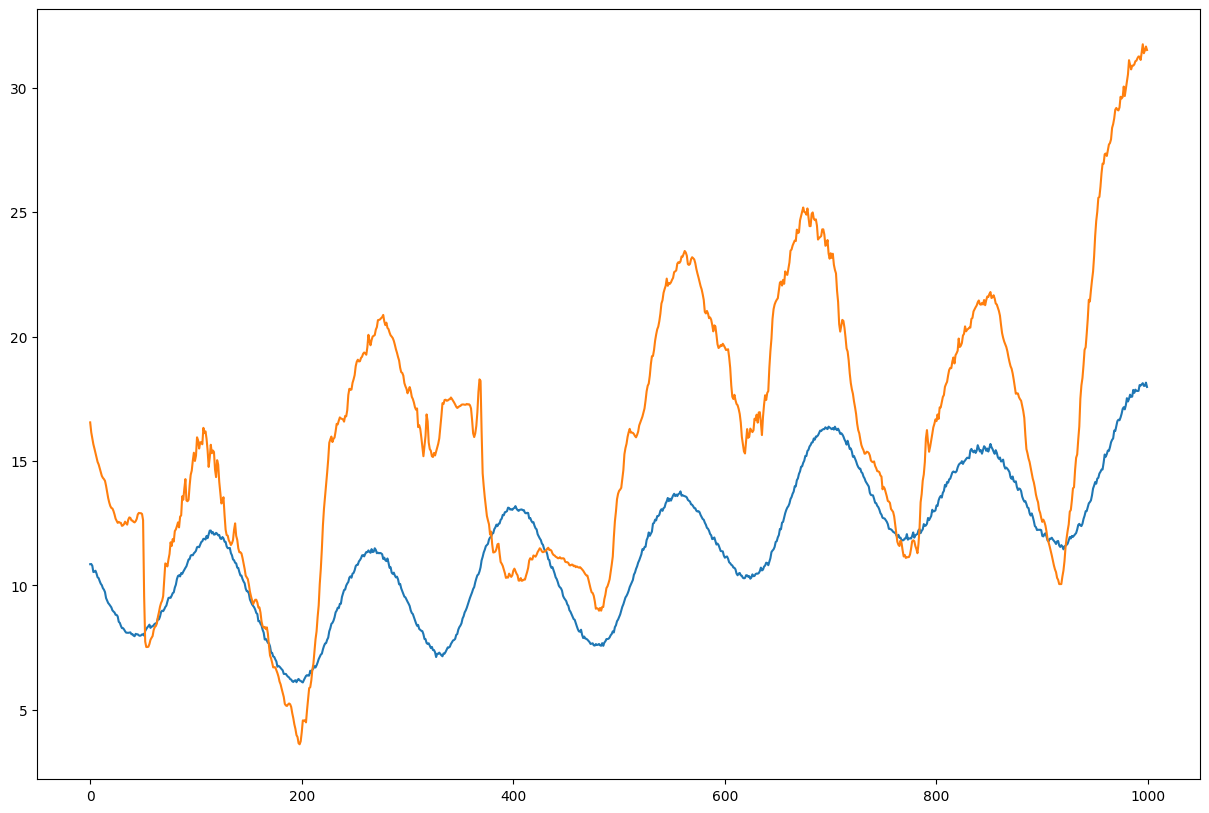

In [ ]:
evaluate_model(
    model=nn_1_model,
    name="NN 1 neurone",
    X_test=X_test,
    y_test=y_test,
    history=history_nn_1_model
)

## Réseau dense profond

In [ ]:
def create_nn_deep_model():
  model = Sequential()

  model.add(Input(shape=input_shape))
  model.add(Flatten())

  # Couches cachées
  model.add(Dense(64, activation="sigmoid"))
  model.add(Dense(100, activation="relu"))
  # model.add(Dropout(0.5))
  model.add(Dense(100, activation="relu"))
  model.add(Dense(16, activation="relu"))
  # model.add(Dropout(0.5))

  # Remarque: les couches de Dropout réduisent la performance du modèle (MAE: ~ 2.44 -> ~ 5.42)

  # Couche de sortie
  model.add(Dense(output_dim, activation="linear")) # Fonction identité

  model.compile(
      optimizer = Adagrad(),
      loss = "mae",
      metrics = ["mae"]
  )
  model.summary()

  return model

In [ ]:
nn_deep_model = create_nn_deep_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 1080)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          69,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │           1,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,417 (341.47 KB)

 Trainable params: 87,417 (341.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nb_epochs = 10

In [ ]:
history_nn_deep_model = nn_deep_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = nb_epochs)

Epoch 1/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 6.4717 - mae: 6.4717 - val_loss: 3.4647 - val_mae: 3.4647
Epoch 2/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 4.3159 - mae: 4.3159 - val_loss: 3.4726 - val_mae: 3.4726
Epoch 3/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 4.0068 - mae: 4.0068 - val_loss: 3.6367 - val_mae: 3.6367
Epoch 4/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 3.8436 - mae: 3.8436 - val_loss: 3.6399 - val_mae: 3.6399
Epoch 5/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 3.7810 - mae: 3.7810 - val_loss: 3.6334 - val_mae: 3.6334
Epoch 6/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 3.7155 - mae: 3.7155 - val_loss: 3.9340 - val_mae: 3.9340
Epoch 7/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 3.6710 - mae: 3.6710 - val_loss: 3.7723 - val_mae: 3.7723
Epoch 8/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 3.6298 - mae: 3.6298 - val_loss: 3.9305 - val_mae: 3.9305
Epoch 9/10
7863/7863 ━━━━━━━━━━━

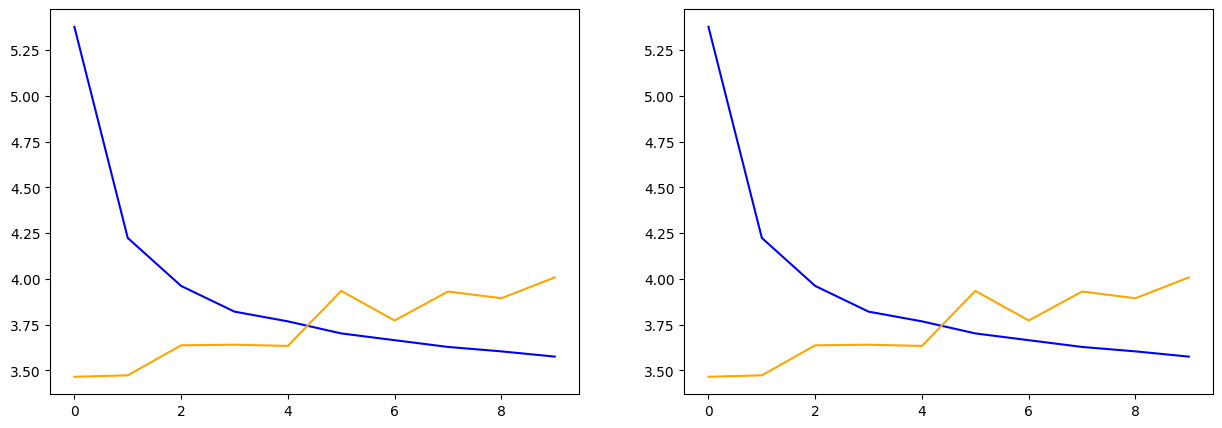

2580/2580 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Comparaison des modèles:
{
  "Modele naif": {
    "MAE": 2.59358882860576
  },
  "NN 1 neurone": {
    "MAE": 3.822216208208877
  },
  "NN profond": {
    "MAE": 5.418930006039181
  }
}


5.418930006039181

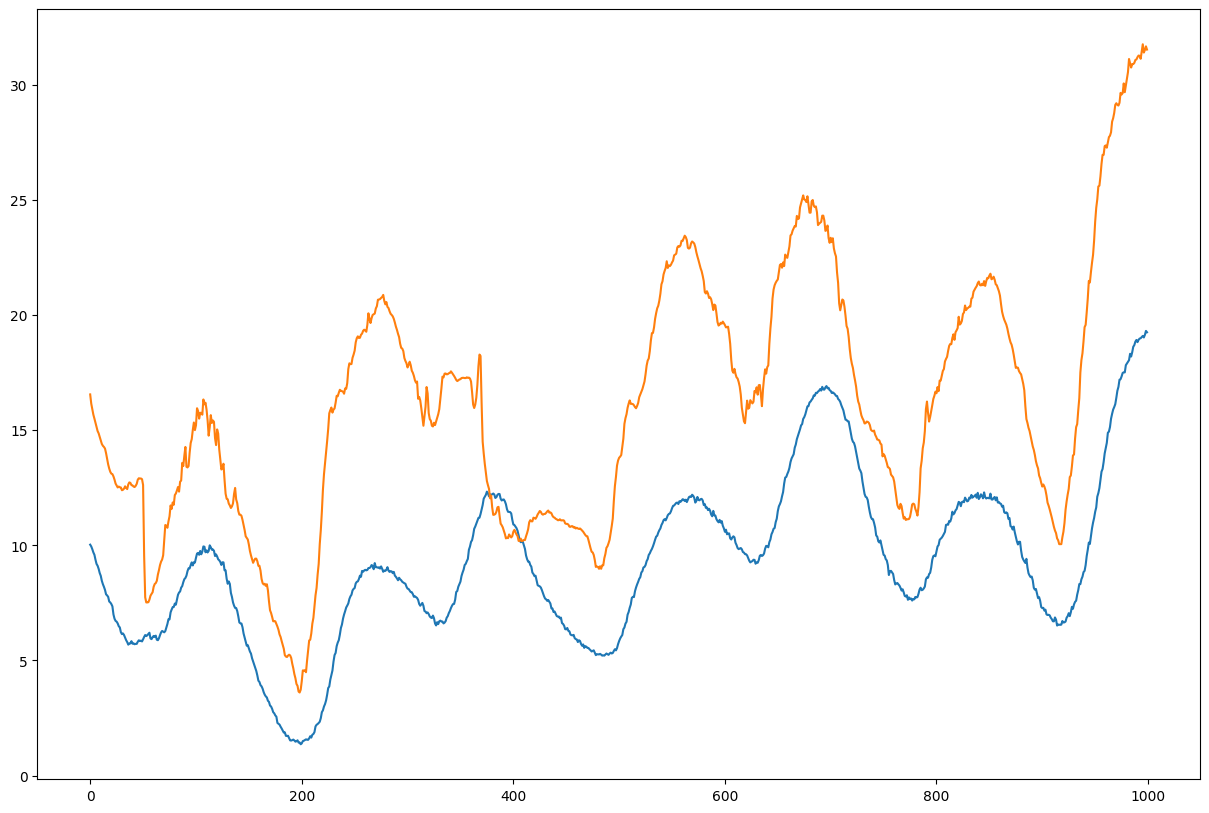

In [ ]:
evaluate_model(
    model=nn_deep_model,
    name="NN profond",
    X_test=X_test,
    y_test=y_test,
    history=history_nn_deep_model
)

## Modèle de convolution 1D

In [ ]:
def create_conv_1d_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  model.add(Conv1D(25, kernel_size=4, activation="relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(16, kernel_size=4, activation="relu"))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(30, activation = "relu"))
  model.add(Dense(30, activation = "relu"))

  model.add(Dense(output_dim, activation = "linear"))

  model.compile(optimizer=Adamax(), loss="mae", metrics=["mae"])

  model.summary()

  return model





In [ ]:
conv_1d_model = create_conv_1d_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 117, 25)             │             925 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 58, 25)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 55, 16)              │           1,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 27, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 27, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 432)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │          12,990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,492 (64.42 KB)

 Trainable params: 16,492 (64.42 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_conv_1d_model = conv_1d_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = nb_epochs)

Epoch 1/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 3.0684 - mae: 3.0684 - val_loss: 3.9081 - val_mae: 3.9081
Epoch 2/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 2.2321 - mae: 2.2321 - val_loss: 3.5290 - val_mae: 3.5290
Epoch 3/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 2.0306 - mae: 2.0306 - val_loss: 3.3220 - val_mae: 3.3220
Epoch 4/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 96s 12ms/step - loss: 1.9154 - mae: 1.9154 - val_loss: 3.5410 - val_mae: 3.5410
Epoch 5/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 1.8298 - mae: 1.8298 - val_loss: 3.4853 - val_mae: 3.4853
Epoch 6/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 135s 10ms/step - loss: 1.7692 - mae: 1.7692 - val_loss: 3.5910 - val_mae: 3.5910
Epoch 7/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 95s 12ms/step - loss: 1.7276 - mae: 1.7276 - val_loss: 3.4893 - val_mae: 3.4893
Epoch 8/10
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - loss: 1.6834 - mae: 1.6834 - val_loss: 3.6434 - val_mae: 3.6434
Epoch 9/10
7863/7863 ━

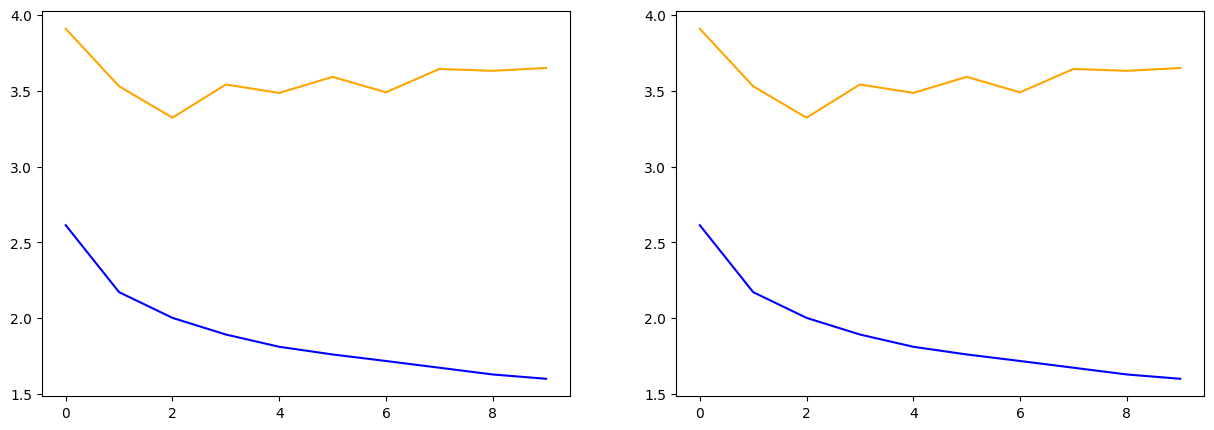

2580/2580 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Comparaison des modèles:
{
  "Modele naif": {
    "MAE": 2.59358882860576
  },
  "NN 1 neurone": {
    "MAE": 3.822216208208877
  },
  "NN profond": {
    "MAE": 5.418930006039181
  },
  "CNN": {
    "MAE": 3.357411743077481
  }
}


3.357411743077481

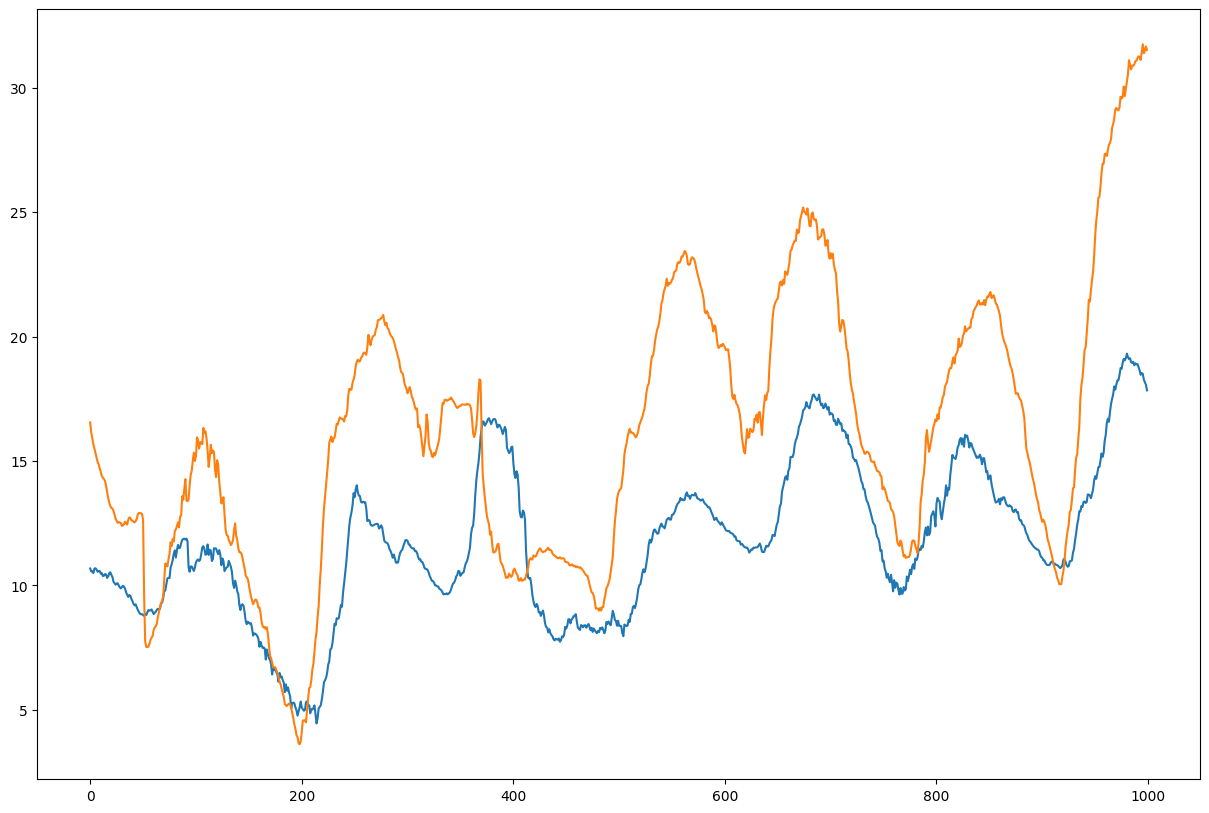

In [ ]:
evaluate_model(
    model=conv_1d_model,
    name="CNN",
    X_test=X_test,
    y_test=y_test,
    history=history_conv_1d_model
)

## Réseau récurrent

In [ ]:
def create_rnn_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  model.add(SimpleRNN(10, activation="relu", return_sequences=True))
  model.add(SimpleRNN(10, activation="relu", return_sequences=False))

  model.add(Dense(output_dim, activation = "linear"))

  model.compile(optimizer=Adamax(), loss="mae", metrics=["mae"])

  model.summary()

  return model

In [ ]:
rnn_model = create_rnn_model()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 120, 10)             │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421 (1.64 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nb_epochs = 1
history_rnn_model = rnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = nb_epochs)

7863/7863 ━━━━━━━━━━━━━━━━━━━━ 389s 49ms/step - loss: 2.8840 - mae: 2.8840 - val_loss: 3.2516 - val_mae: 3.2516


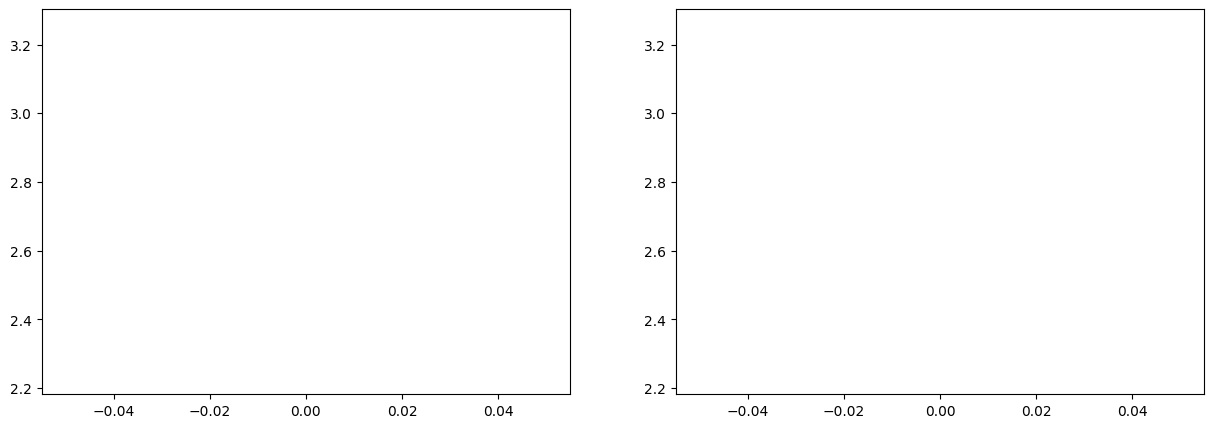

2580/2580 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step
Comparaison des modèles:
{
  "Modele naif": {
    "MAE": 2.59358882860576
  },
  "NN 1 neurone": {
    "MAE": 3.822216208208877
  },
  "NN profond": {
    "MAE": 5.418930006039181
  },
  "CNN": {
    "MAE": 3.357411743077481
  },
  "RNN": {
    "MAE": 2.257179331601453
  }
}


2.257179331601453

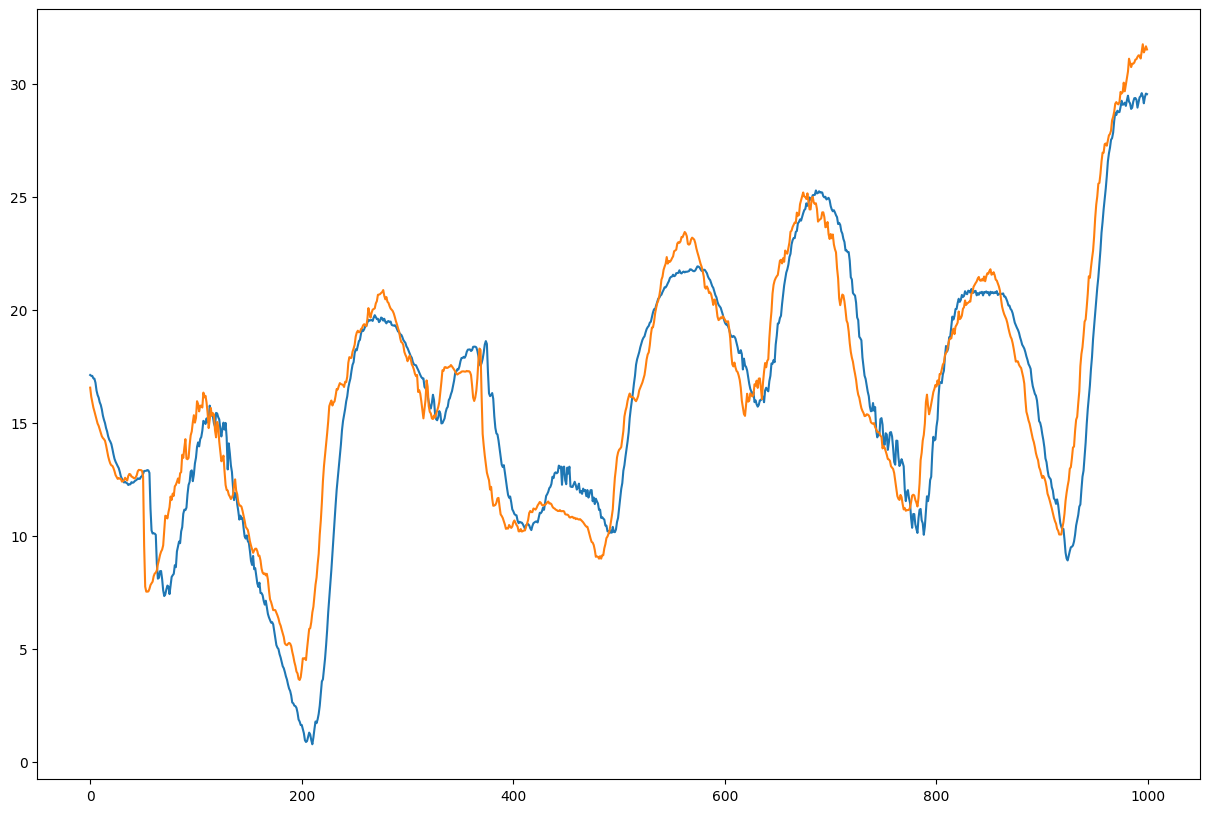

In [ ]:
evaluate_model(
    model=rnn_model,
    name="RNN",
    X_test=X_test,
    y_test=y_test,
    history=history_rnn_model
)

## LSTM

In [ ]:
def create_lstm_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  model.add(LSTM(10, activation="relu", return_sequences=True))
  model.add(LSTM(10, activation="relu", return_sequences=False))

  model.add(Dense(output_dim, activation = "linear"))

  model.compile(optimizer=Adamax(), loss="mae", metrics=["mae"])

  model.summary()

  return model

In [ ]:
lstm_model = create_lstm_model()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 120, 10)             │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,651 (6.45 KB)

 Trainable params: 1,651 (6.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nb_epochs = 3
history_lstm_model = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = nb_epochs)

Epoch 1/5
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 617s 78ms/step - loss: 2.8916 - mae: 2.8916 - val_loss: 3.3810 - val_mae: 3.3810
Epoch 2/5
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 603s 76ms/step - loss: 1.9076 - mae: 1.9076 - val_loss: 3.1790 - val_mae: 3.1790
Epoch 3/5
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 601s 76ms/step - loss: 1.3386 - mae: 1.3386 - val_loss: 3.4672 - val_mae: 3.4672
Epoch 4/5
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 591s 75ms/step - loss: 1.0463 - mae: 1.0463 - val_loss: 3.1560 - val_mae: 3.1560
Epoch 5/5
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 596s 76ms/step - loss: 0.6741 - mae: 0.6741 - val_loss: 3.5022 - val_mae: 3.5022


In [ ]:
evaluate_model(
    model=lstm_model,
    name="LSTM",
    X_test=X_test,
    y_test=y_test,
    history=history_lstm_model
)

## GRU

In [ ]:
def create_gru_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  model.add(GRU(10, activation="relu", return_sequences=True))
  model.add(GRU(10, activation="relu", return_sequences=False))

  model.add(Dense(output_dim, activation = "linear"))

  model.compile(optimizer=Adamax(), loss="mae", metrics=["mae"])

  model.summary()

  return model

In [ ]:
gru_model = create_gru_model()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 120, 10)             │             630 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,301 (5.08 KB)

 Trainable params: 1,301 (5.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nb_epochs = 1
history_gru_model = gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = nb_epochs)

7863/7863 ━━━━━━━━━━━━━━━━━━━━ 679s 86ms/step - loss: 3.4213 - mae: 3.4213 - val_loss: 3.2908 - val_mae: 3.2908


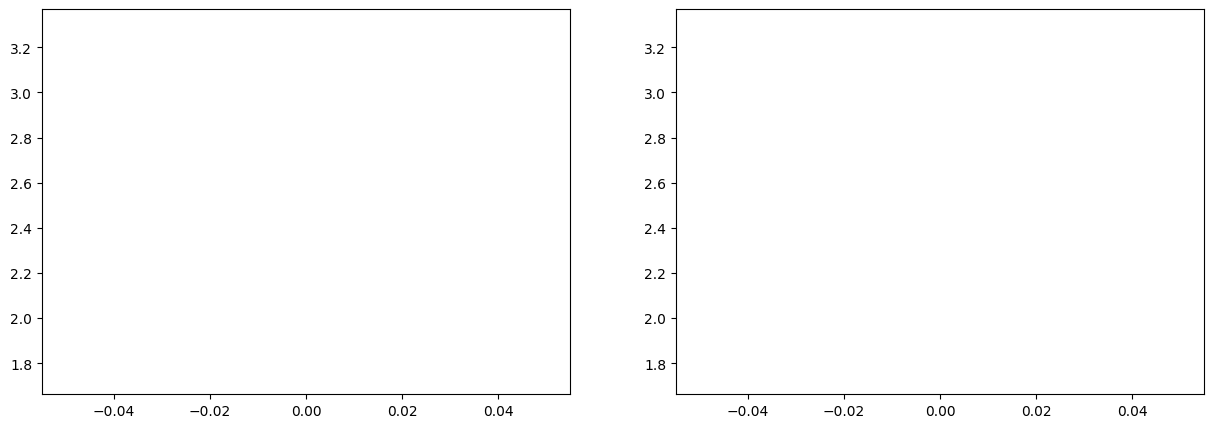

2580/2580 ━━━━━━━━━━━━━━━━━━━━ 65s 25ms/step
Comparaison des modèles:
{
  "Modele naif": {
    "MAE": 2.59358882860576
  },
  "NN 1 neurone": {
    "MAE": 3.822216208208877
  },
  "NN profond": {
    "MAE": 5.418930006039181
  },
  "CNN": {
    "MAE": 3.357411743077481
  },
  "RNN": {
    "MAE": 2.257179331601453
  },
  "LSTM": {
    "MAE": 10.327943842464341
  },
  "GRU": {
    "MAE": 1.6806061623867856
  }
}


1.6806061623867856

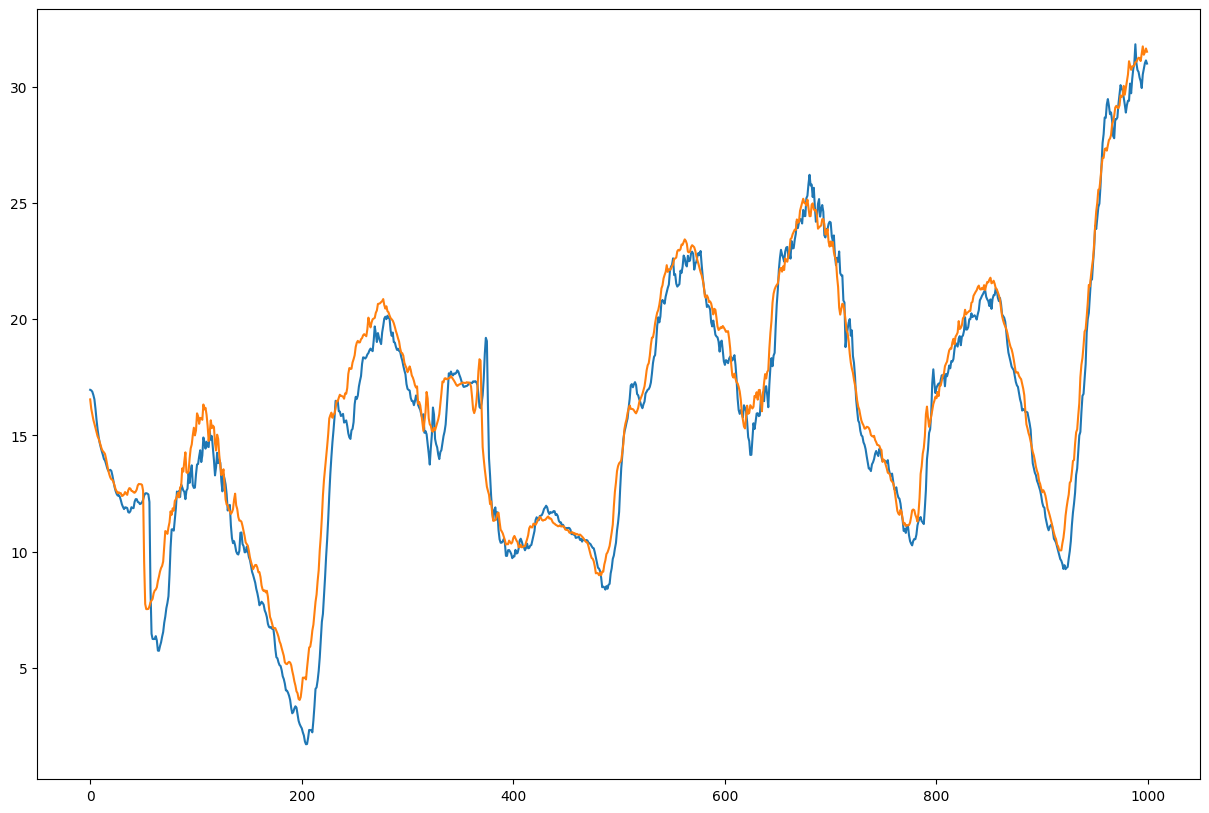

In [ ]:
evaluate_model(
    model=gru_model,
    name="GRU",
    X_test=X_test,
    y_test=y_test,
    history=history_gru_model
)